In [17]:
from dataclasses import dataclass
import os
from pathlib import Path
from plyfile import PlyData
import numpy as np

experiment = Path(
    '/home/aq85800/NewVolume/gsplat/dual_bw_bg+sh-degree=0+elongation-reg=2e-2/cloud+small+nobg+200mocap_bogusorange32e3_correctcams/colmap_47/2025-07-16T12:58-04:00')
experiment_pretty_name = Path('__'.join(experiment.parts[-4:]))
os.makedirs(experiment_pretty_name,exist_ok=True)

ply = sorted(
    (experiment/"ply").glob('point_cloud_*.ply'),
    key=lambda f: f.stat().st_mtime,
    reverse=True
)[0]

plydata = PlyData.read(ply)
xyz = np.array([plydata['vertex'][d]
               for d in ['x', 'y', 'z']]).T  # [N x (x,y,z)]
print(xyz)

# extend box so that the gaussian is on aabb's outer edge
aabb_min = np.min(xyz, 0) * (1+1e-3)
aabb_max = np.max(xyz, 0) * (1+1e-3)
aabb_n_cells = np.array([2,2,1]) * 64
aabb_cell_size = (aabb_max-aabb_min)/aabb_n_cells
print(np.vstack((aabb_min, aabb_max, aabb_cell_size)))

voxel_ids = np.floor((xyz - aabb_min) / aabb_cell_size).astype(int)
print(voxel_ids)

voxels = np.zeros(aabb_n_cells, dtype=np.float64)
for i,j,k in voxel_ids:
    voxels[i,j,k] += 1
assert voxels.sum() == xyz.shape[0], 'Gaussian counting error'
print(voxels)

min=voxels.min()
max=voxels.max()


[[-0.03372296 -0.09001186  0.00426309]
 [ 0.27140957  0.15995342 -0.09268662]
 [-0.20961381  0.8745211  -0.24131964]
 ...
 [-0.08852176 -0.11006698  0.35042173]
 [-0.0693052  -0.05506577  0.36705396]
 [-0.06662486 -0.1147954   0.34183905]]
[[-0.94404805 -0.94158649 -0.33043158]
 [ 0.93188643  0.94383937  0.43547255]
 [ 0.01465574  0.01472989  0.01196725]]
[[ 62  57  27]
 [ 82  74  19]
 [ 50 123   7]
 ...
 [ 58  56  56]
 [ 59  60  58]
 [ 59  56  56]]
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 

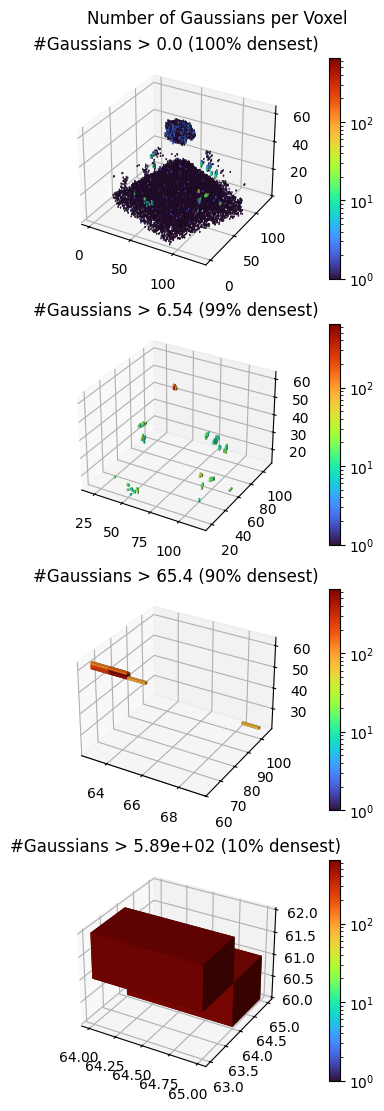

In [18]:
from matplotlib.cm import ScalarMappable
from matplotlib.colors import ListedColormap, Normalize, LogNorm
from matplotlib.figure import Figure
import matplotlib.pyplot as plt
import seaborn as sb


def alpha_gradient(cmap, lut, amin, amax):
    original = plt.get_cmap(cmap)(np.linspace(0,1,lut))
    alphas = np.linspace(amin, amax, num=lut)
    original[...,3] = alphas
    return ListedColormap(original)

# TODO colormap in logspace

# alpha_grad_cmap = alpha_gradient('turbo', 128, .8, 1.)
alpha_grad_cmap = plt.get_cmap('turbo')
norm=LogNorm(vmin=min+1,vmax=max+1)
# norm = Normalize(vmin=min, vmax=max)
mappable = ScalarMappable(norm=norm, cmap=alpha_grad_cmap)
# blend = (np.log1p(voxels) - np.log1p(min))/(np.log1p(max)-np.log1p(min))
# faces = alpha_grad_cmap(blend)
faces = np.array(alpha_grad_cmap(norm(voxels.flatten())))
faces = faces.reshape([*voxels.shape, 4])

densest_visibilities = [1.,.99,.9,.1]

fig = plt.figure(figsize=(8.5,11))
fig.set_layout_engine('compressed')
fig.suptitle("Number of Gaussians per Voxel")

axs=fig.subplots(nrows=len(densest_visibilities),subplot_kw={"projection":'3d'})
for densest_visibility,ax in zip(densest_visibilities,axs):
    vis_min = (1-densest_visibility) * (max-min) + min
    _=ax.set_title(f"#Gaussians > {vis_min:.3} ({densest_visibility:.0%} densest)")
    _=ax.voxels(filled=voxels>vis_min , facecolors=faces) # TODO slice by slice
    fig.colorbar(mappable,ax=ax)

fig.savefig(experiment_pretty_name/'3d.svg')


/tmp/ipykernel_936762/981188706.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1,1)


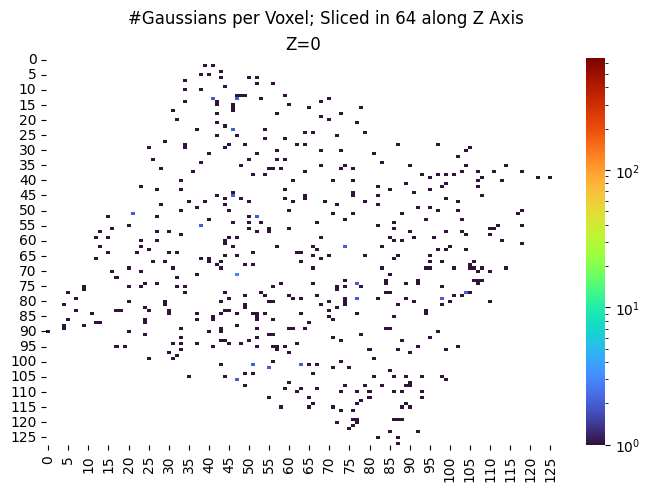

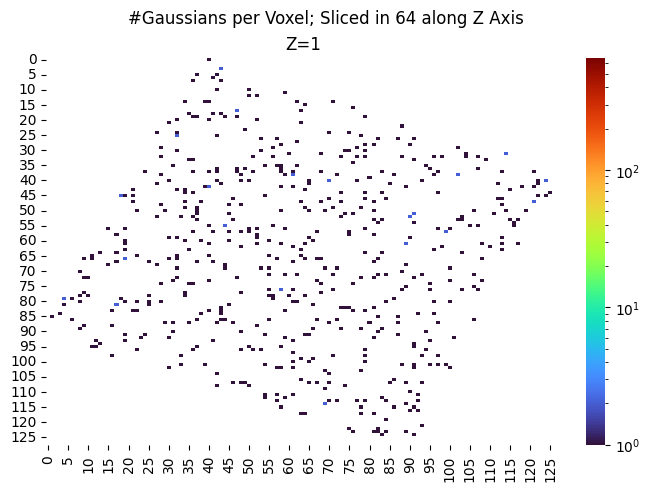

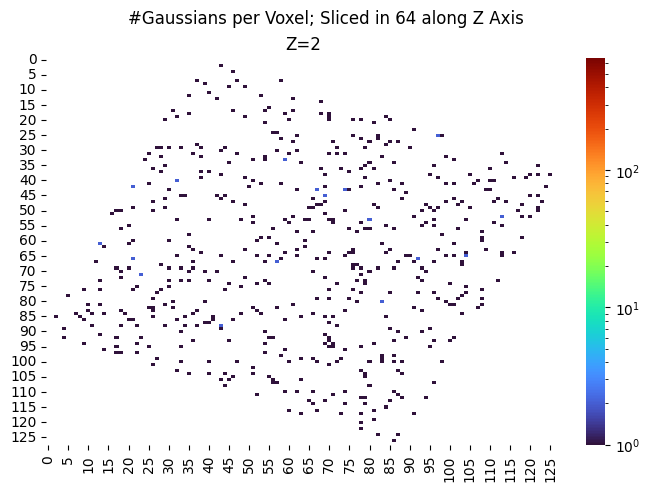

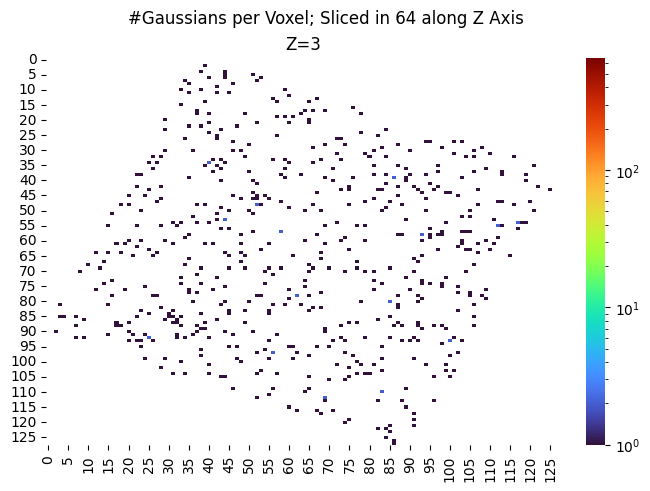

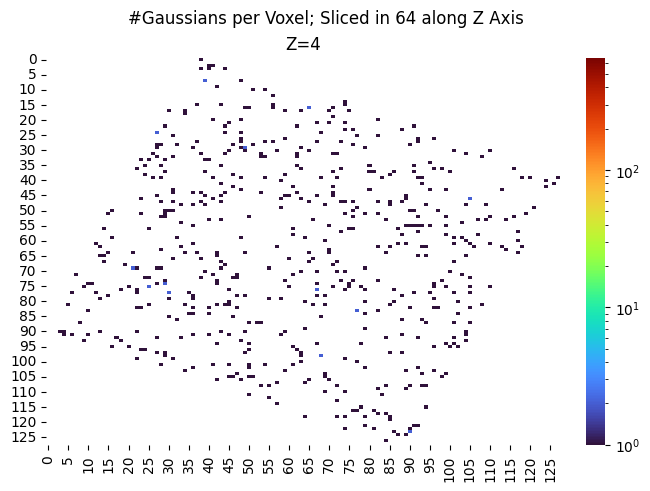

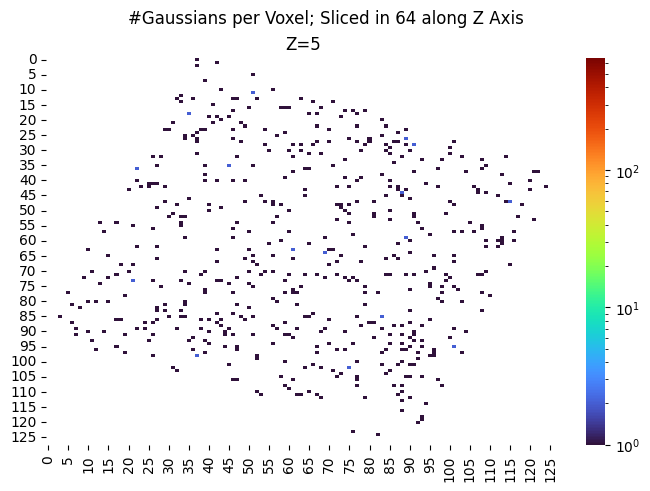

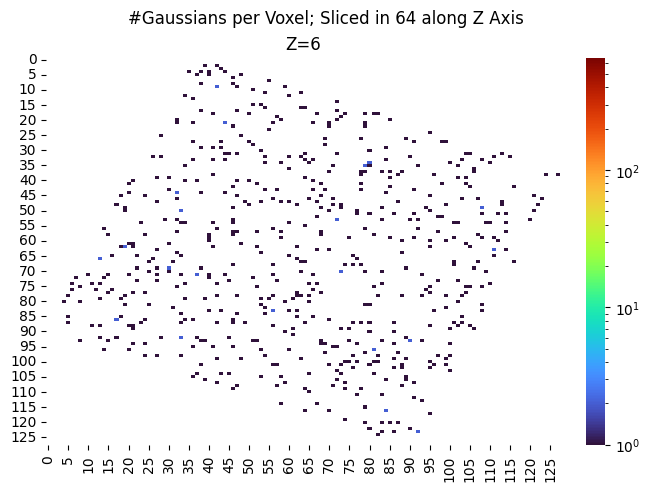

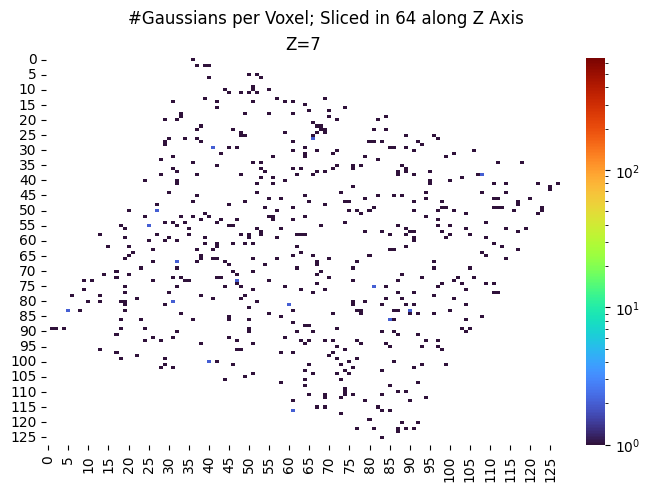

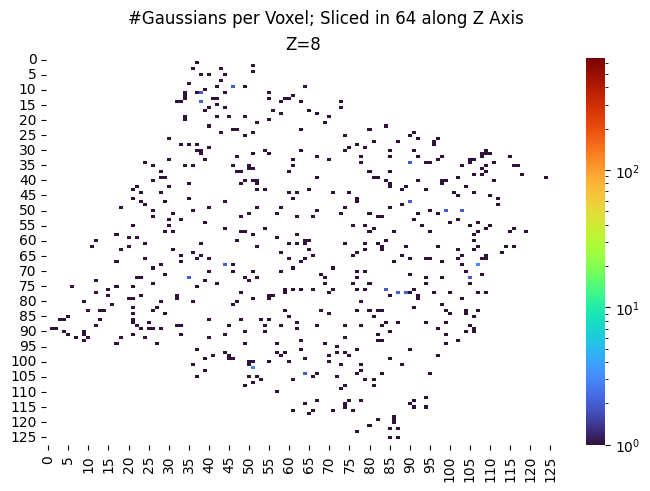

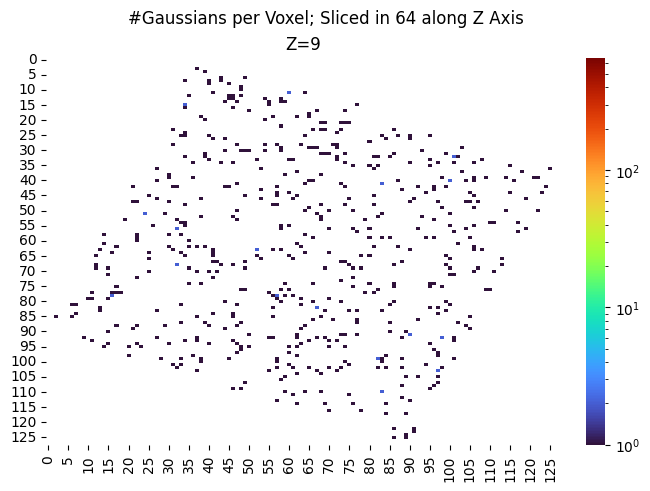

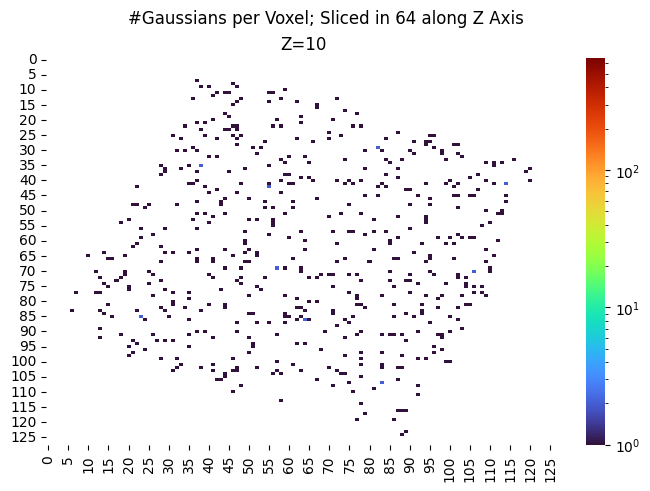

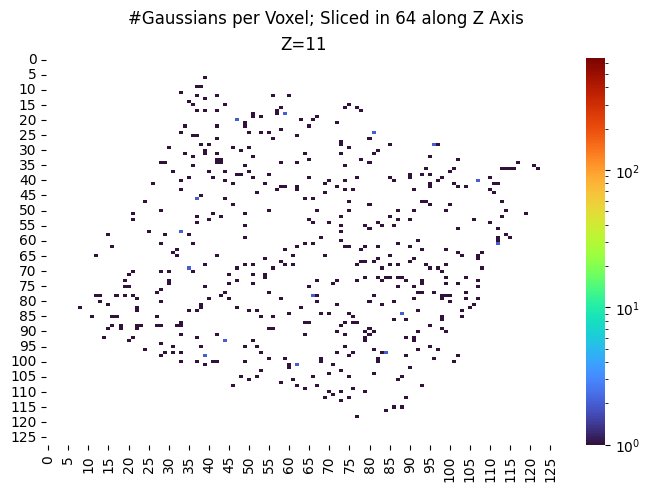

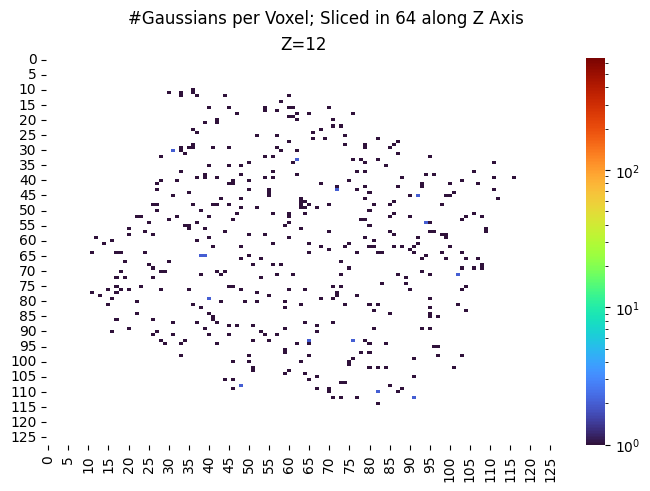

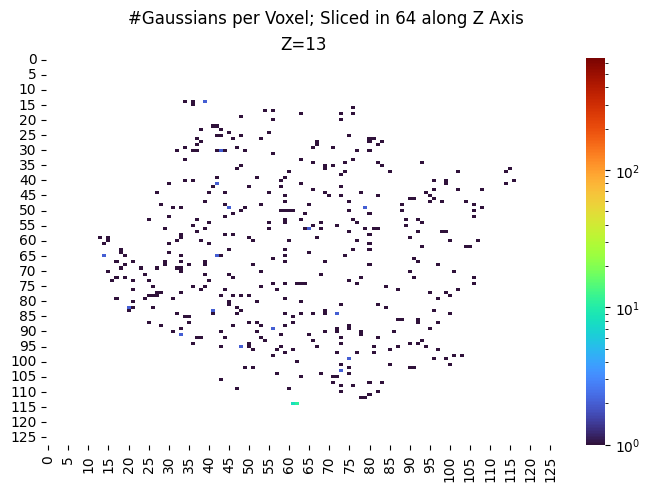

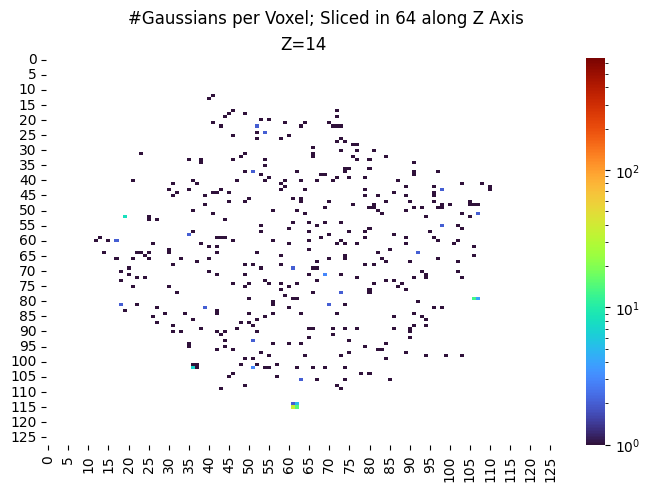

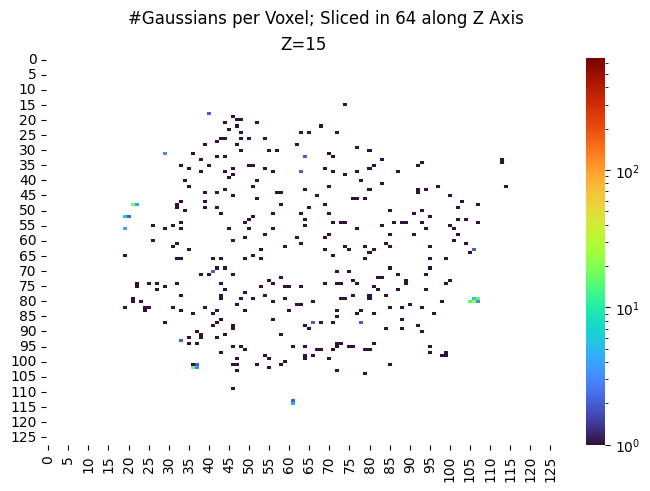

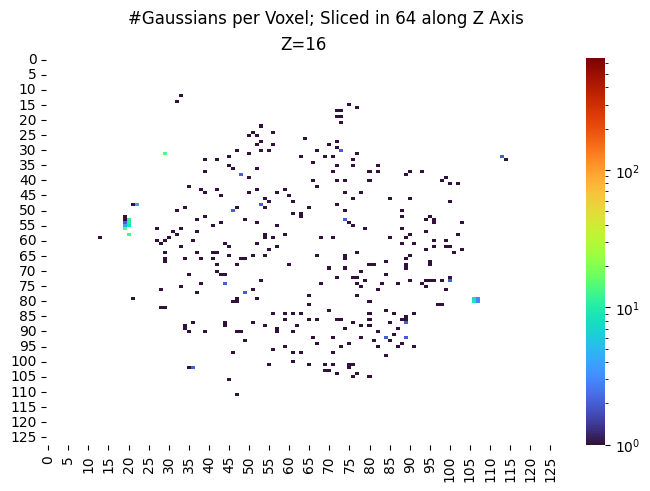

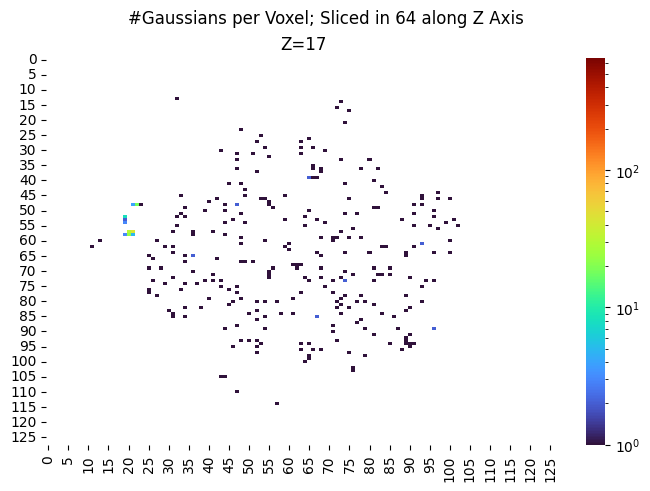

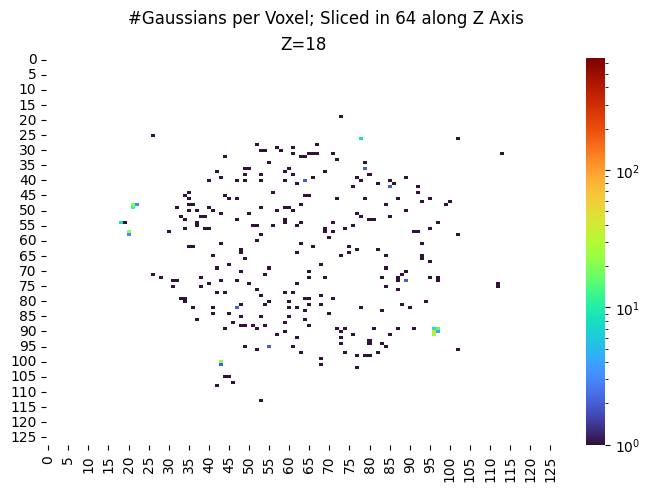

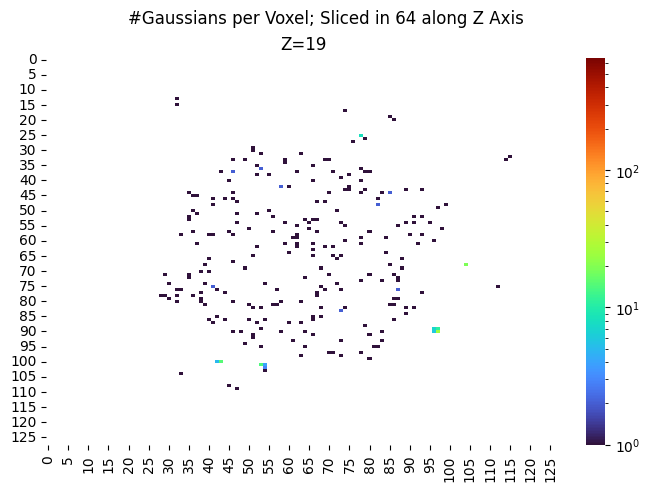

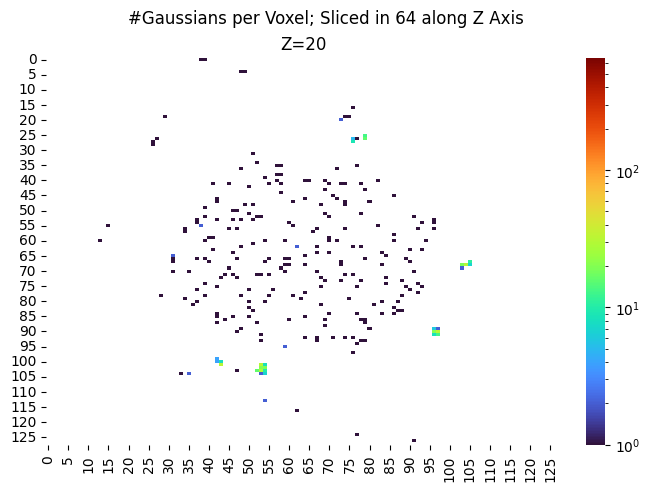

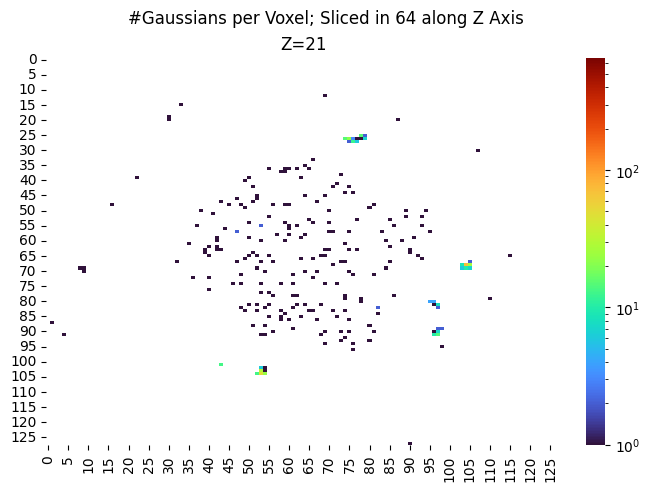

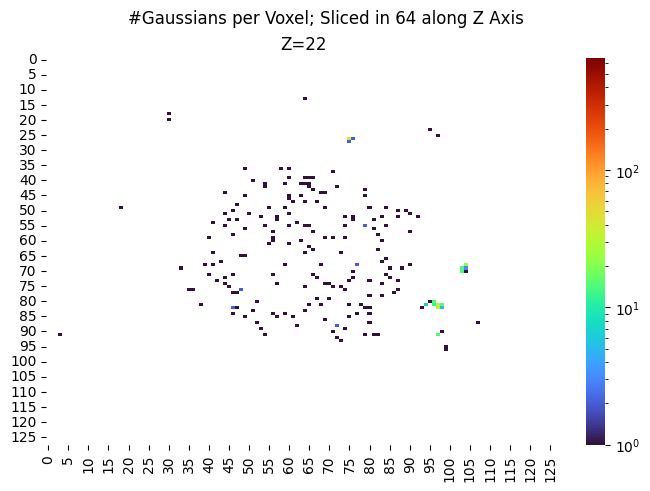

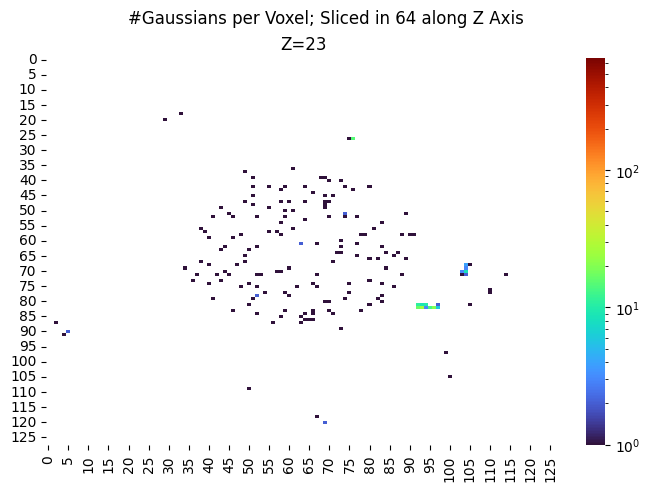

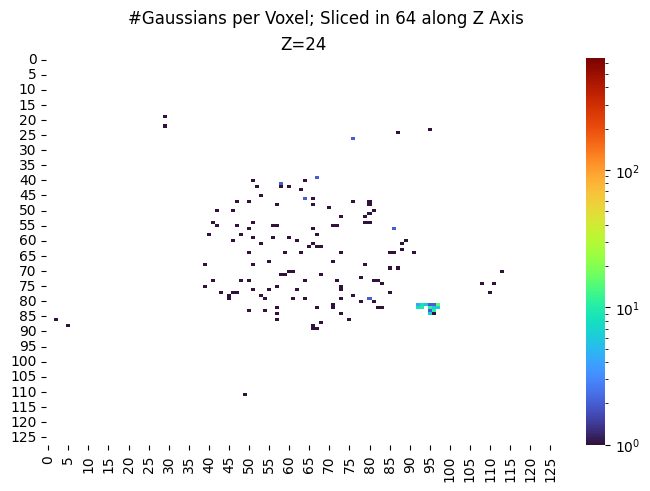

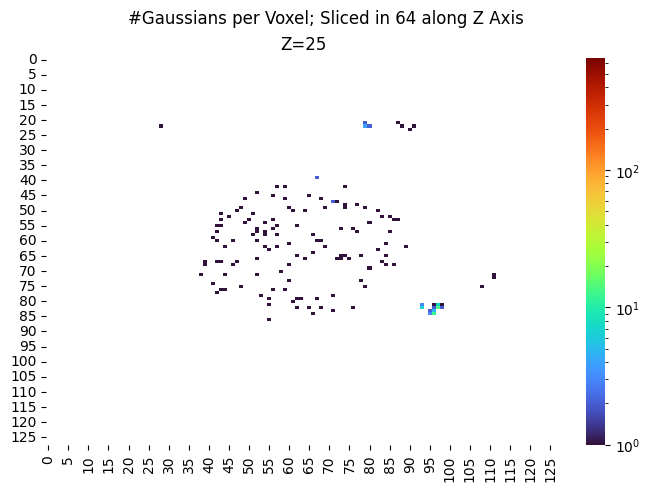

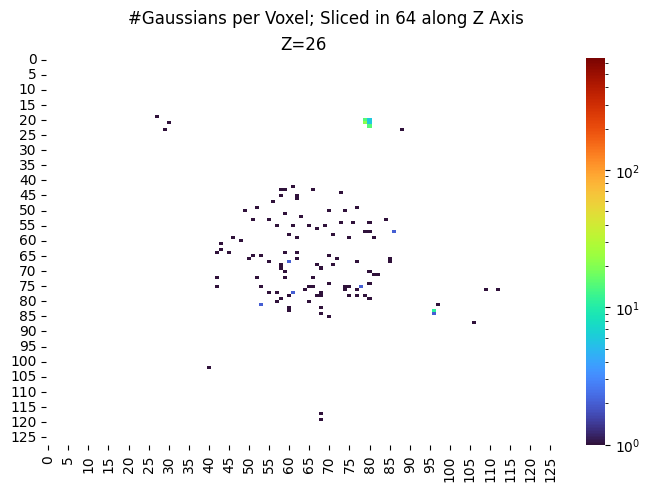

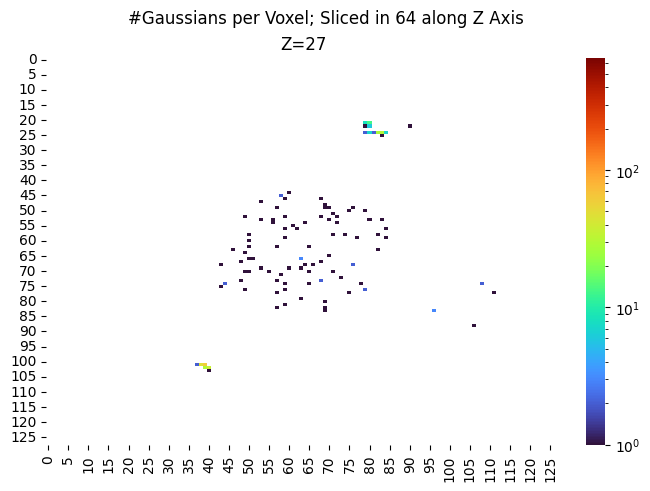

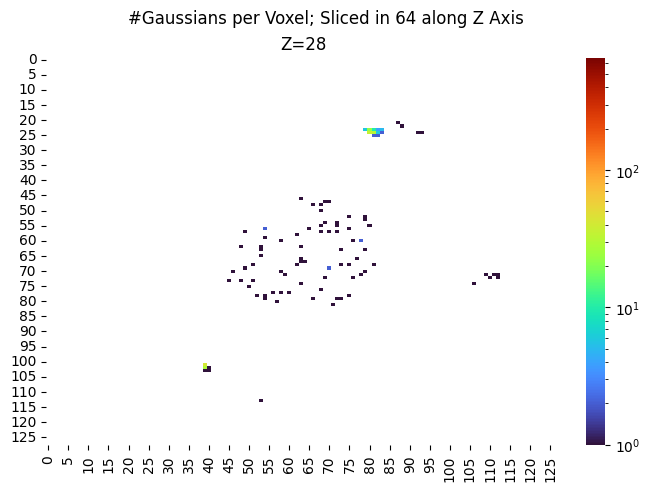

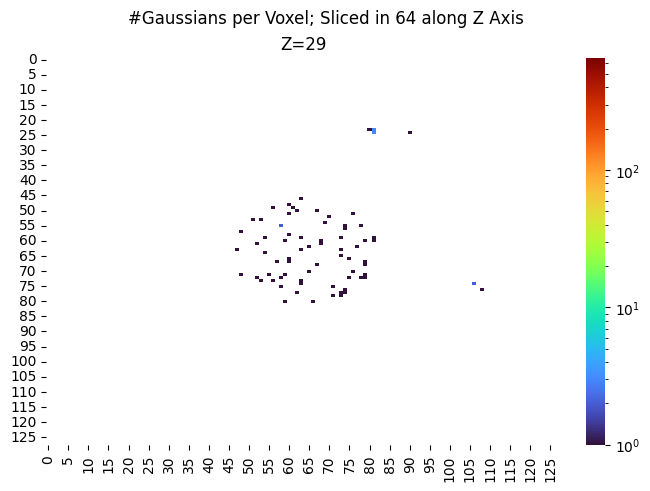

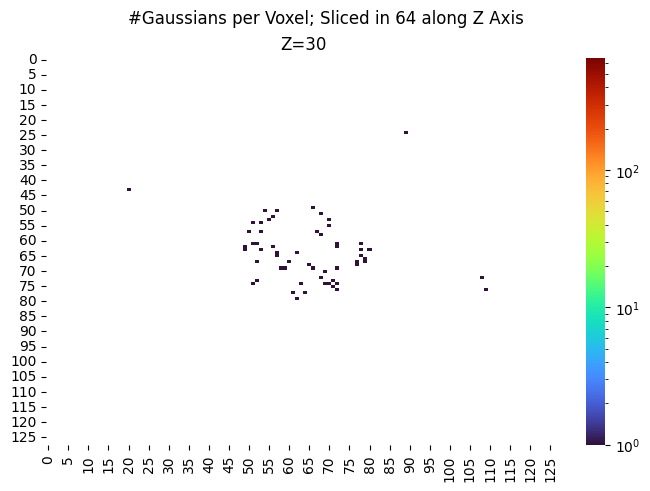

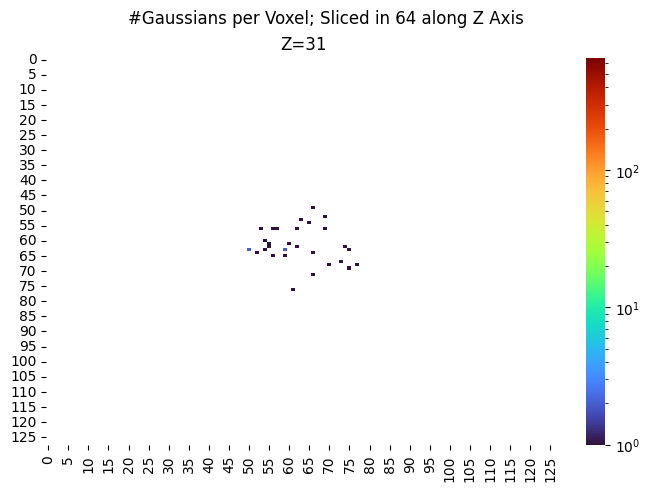

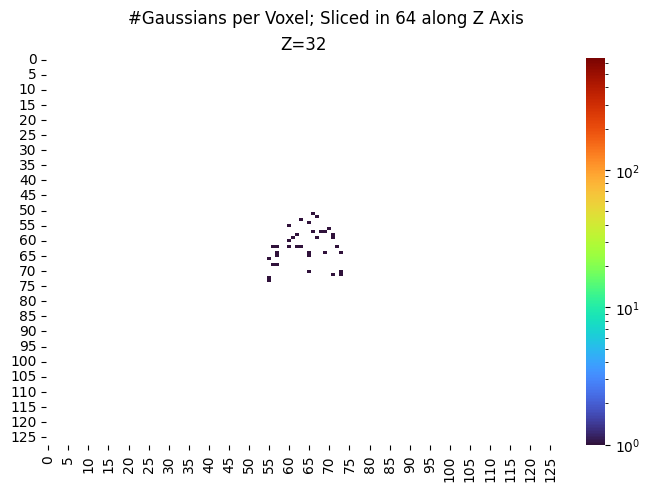

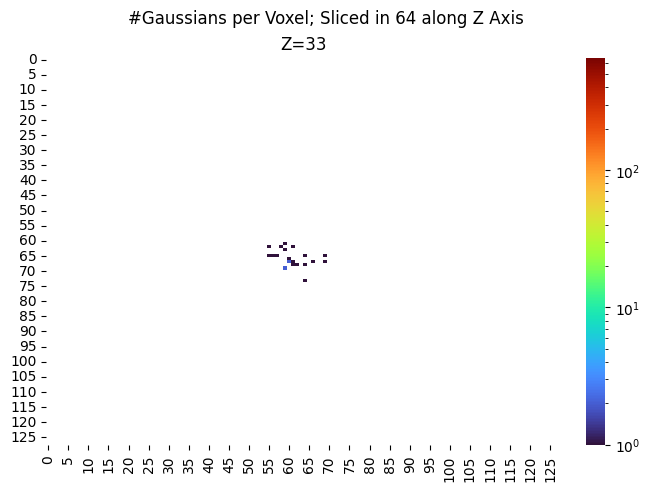

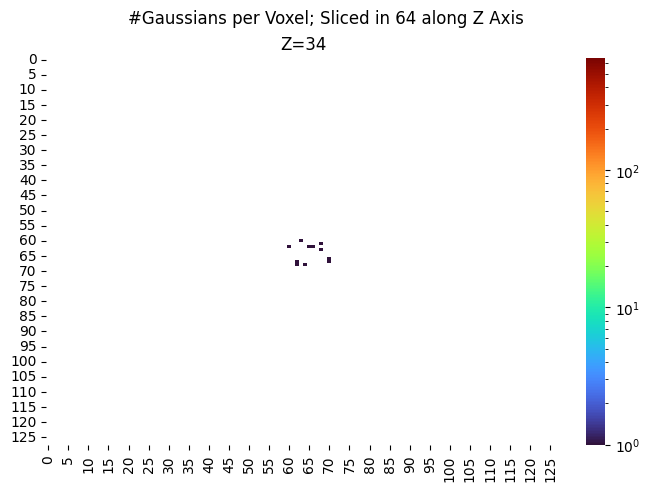

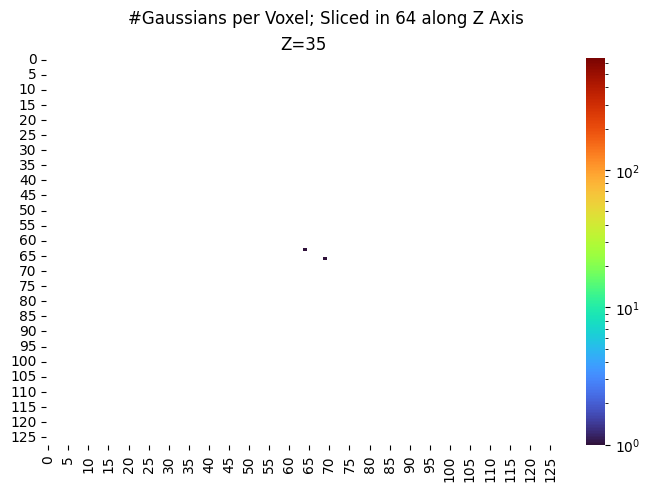

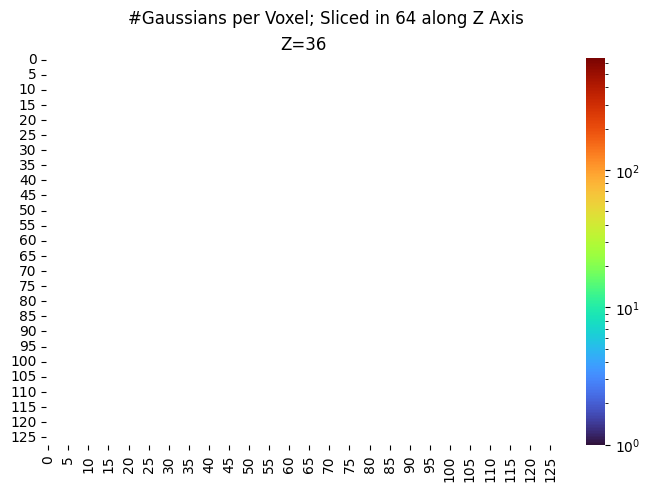

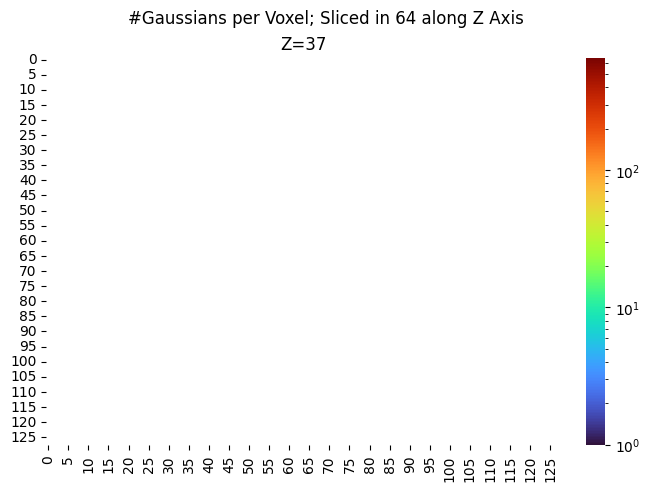

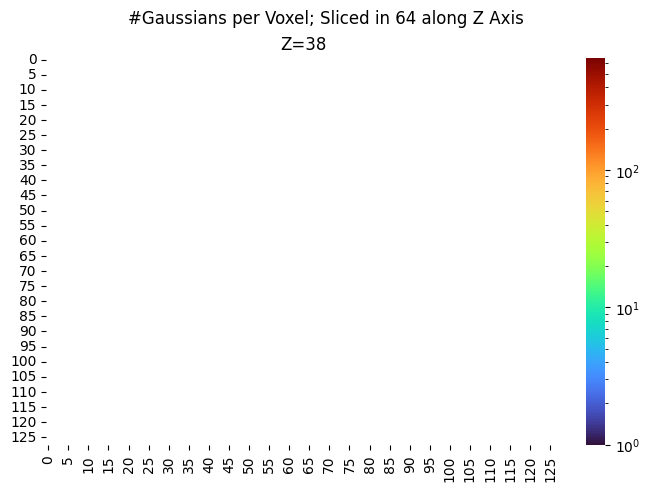

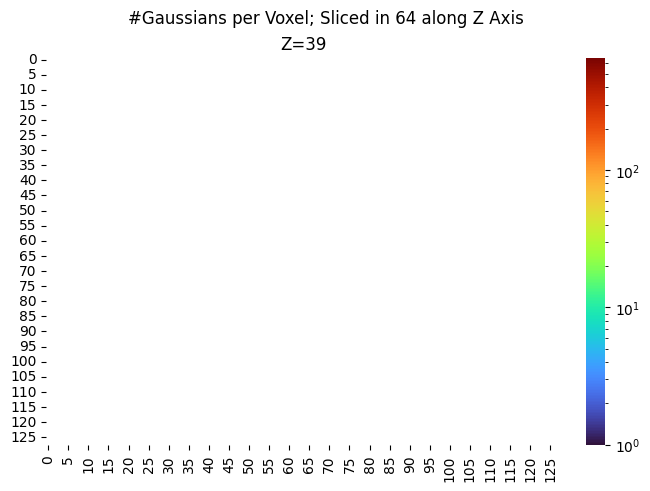

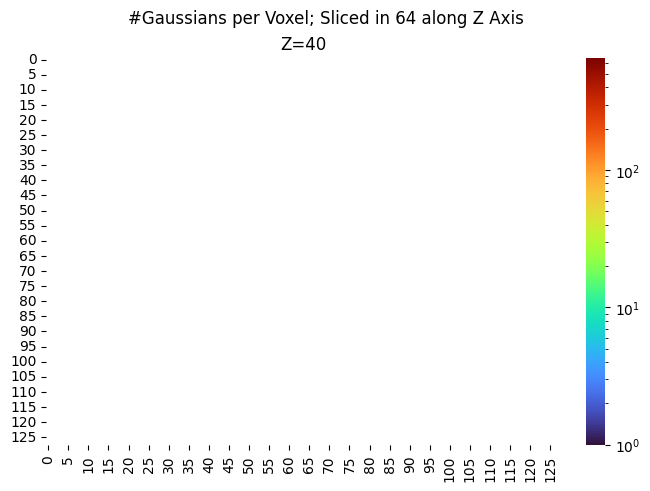

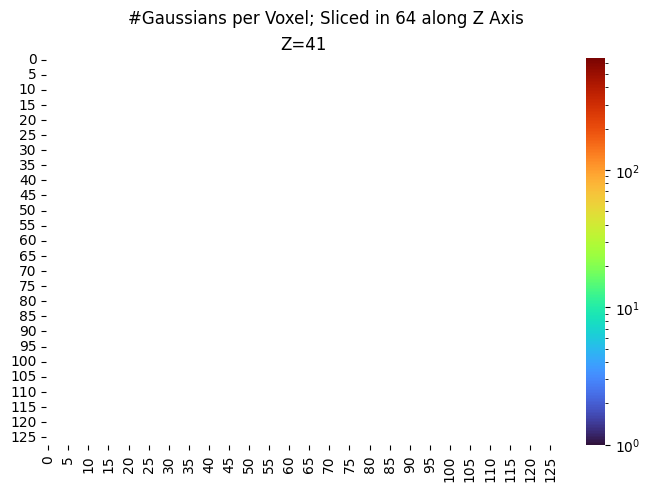

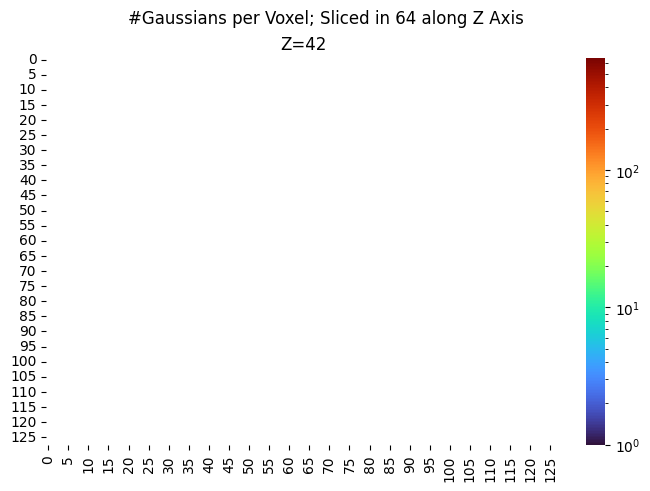

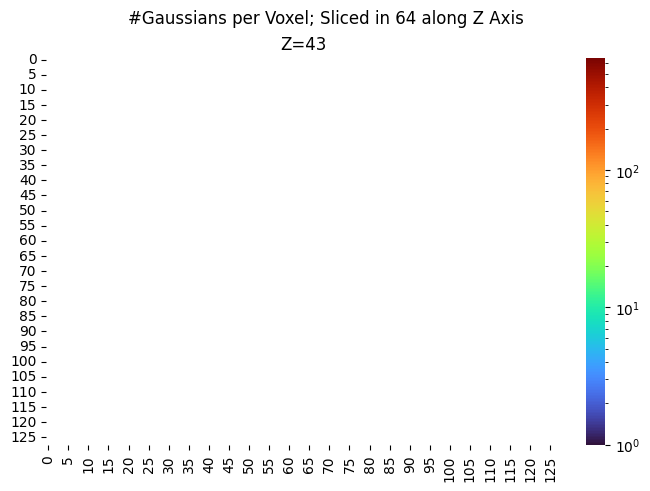

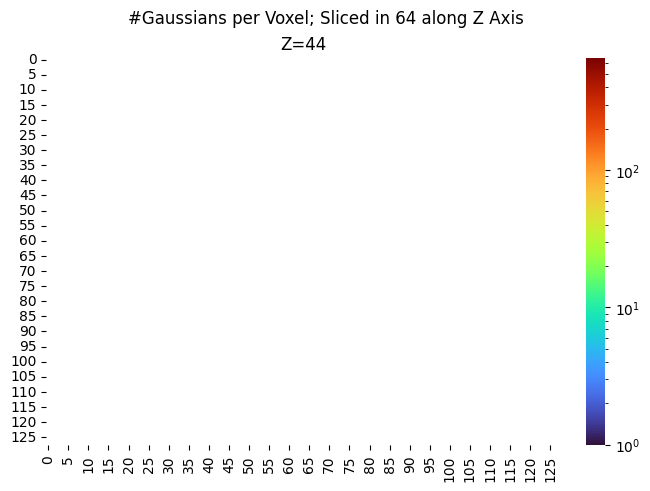

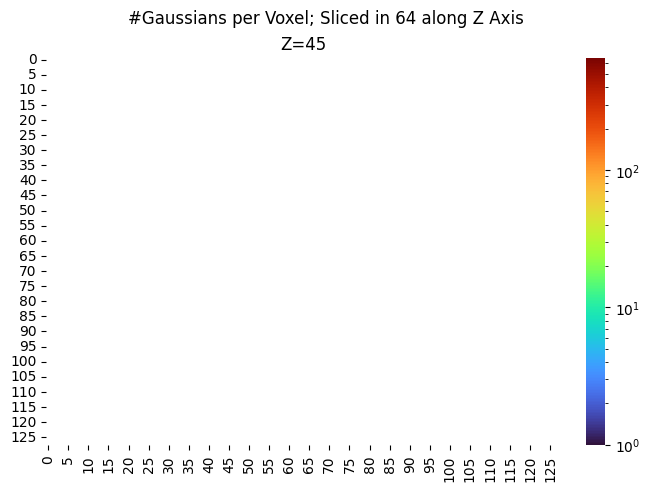

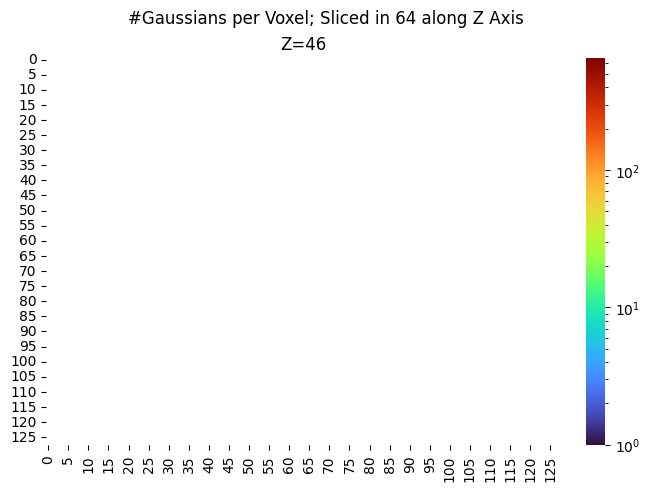

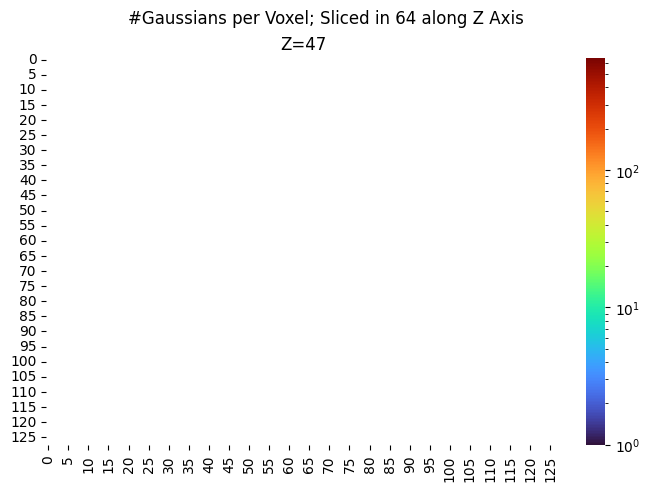

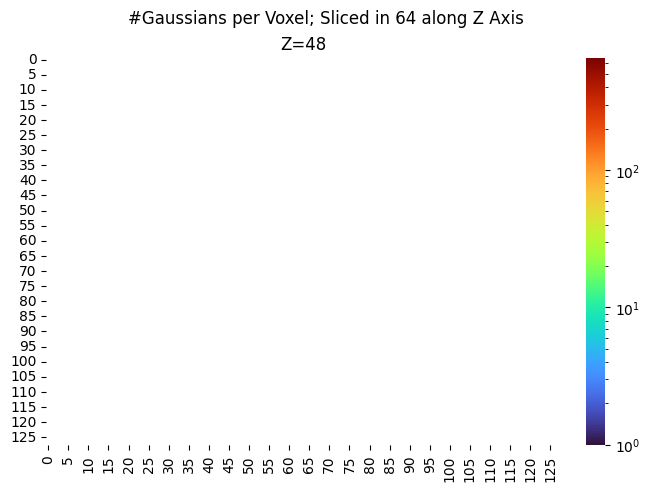

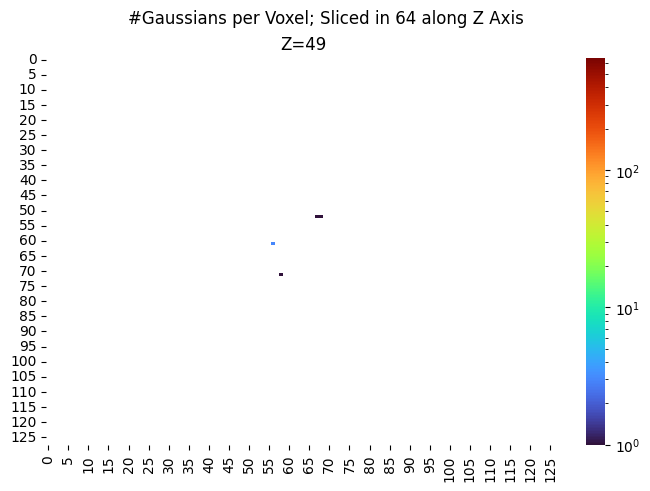

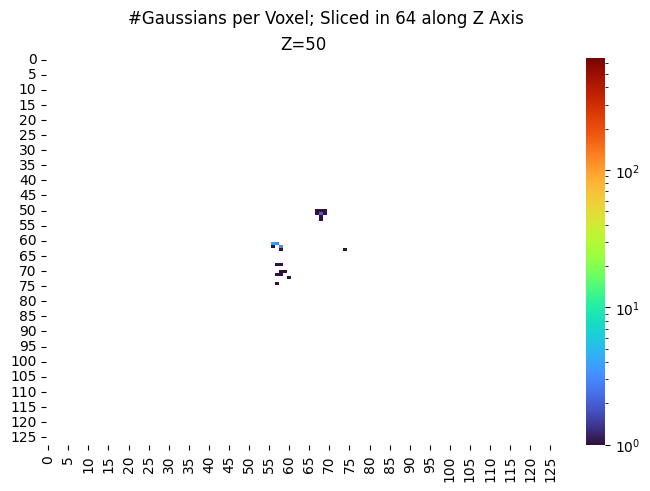

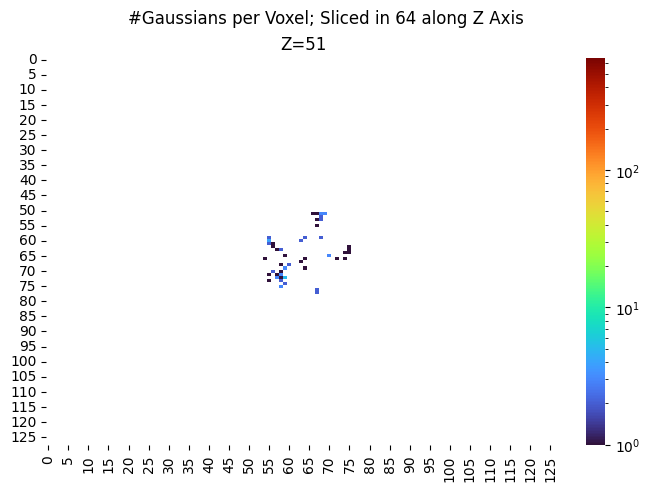

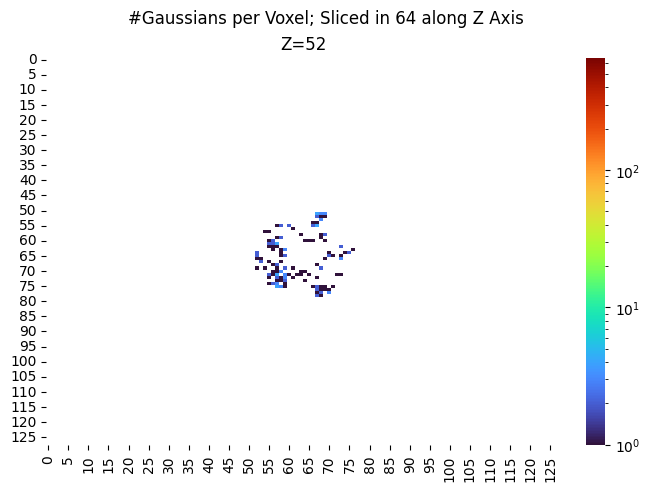

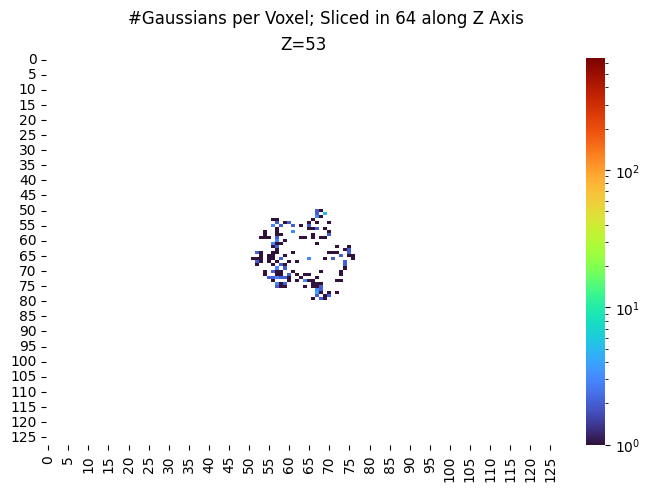

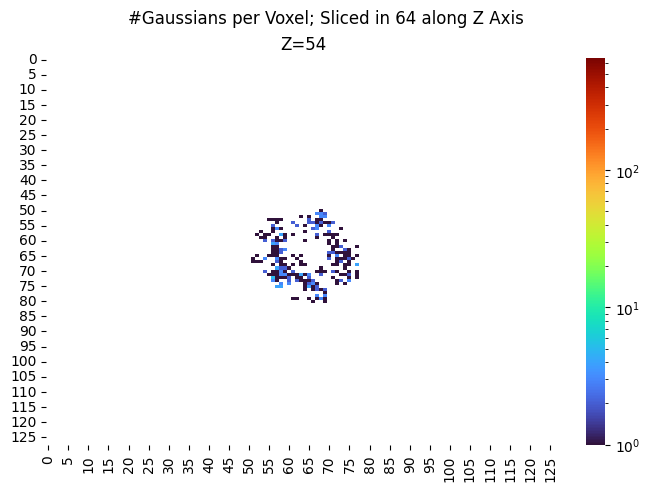

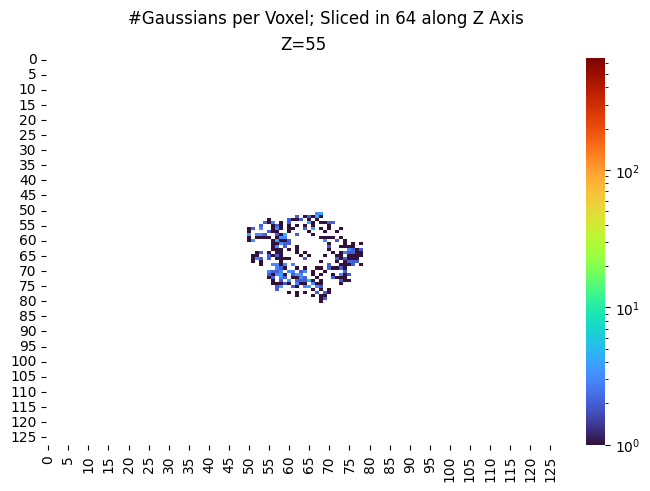

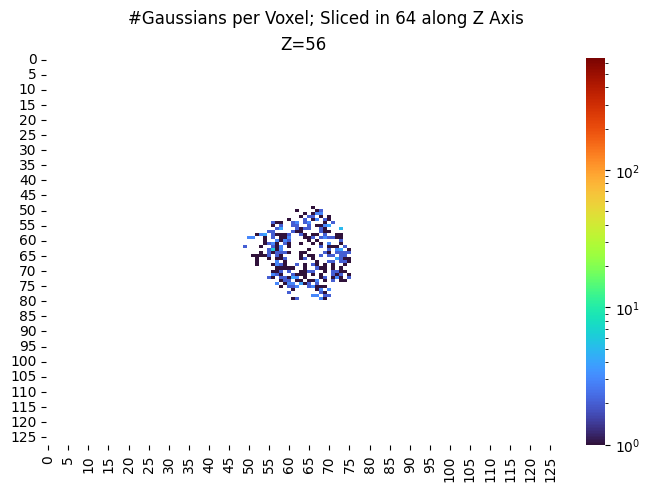

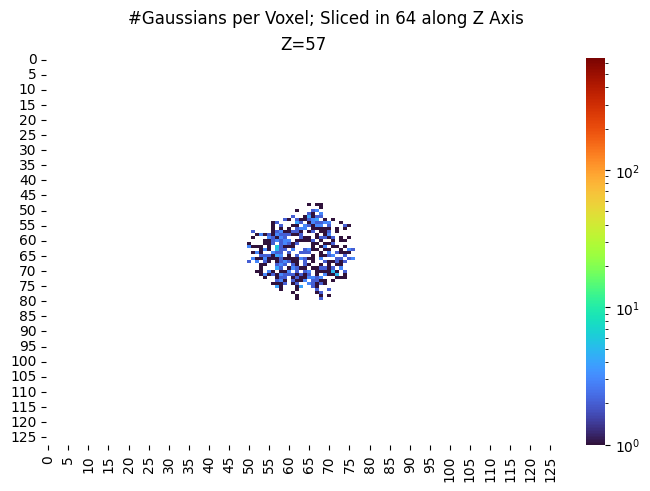

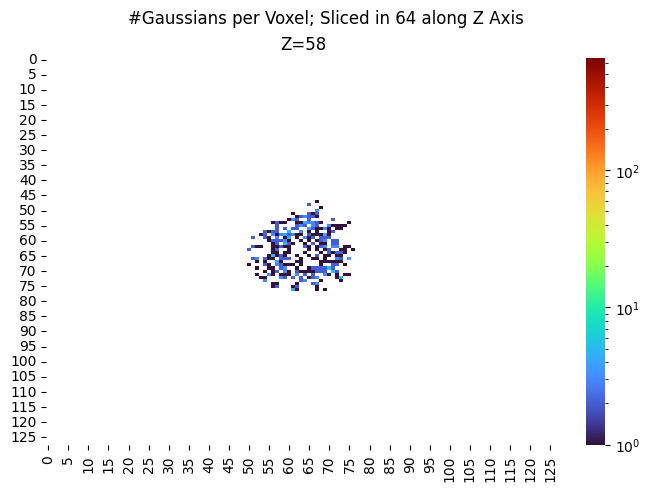

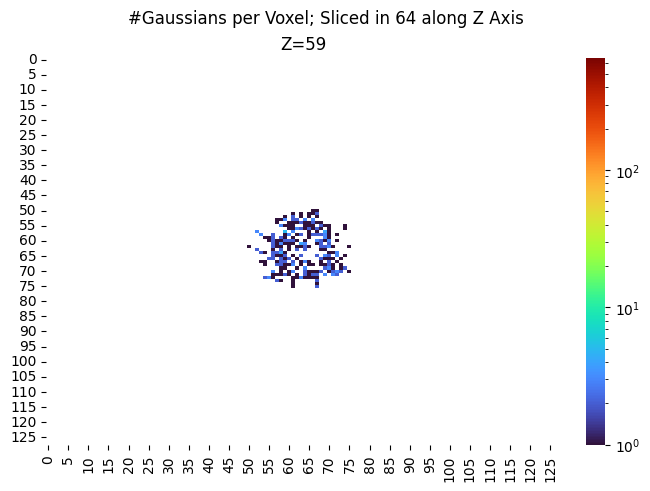

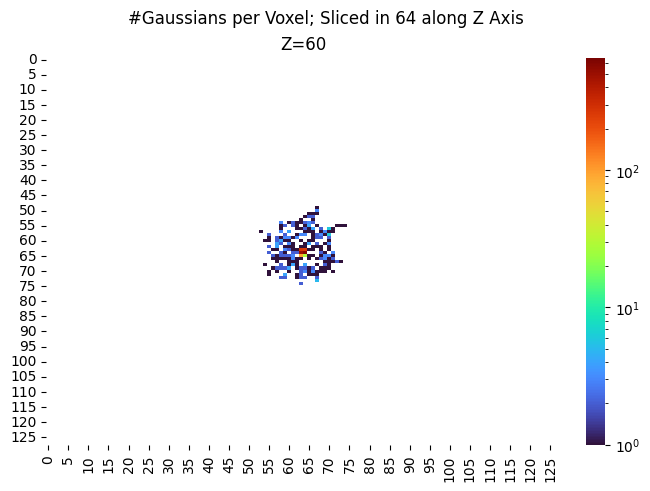

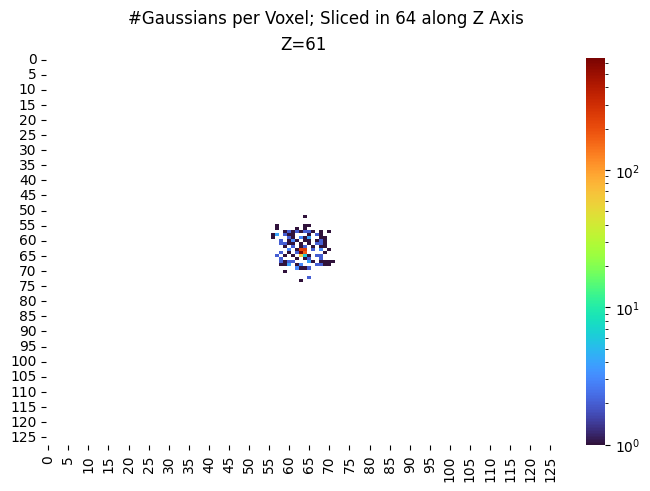

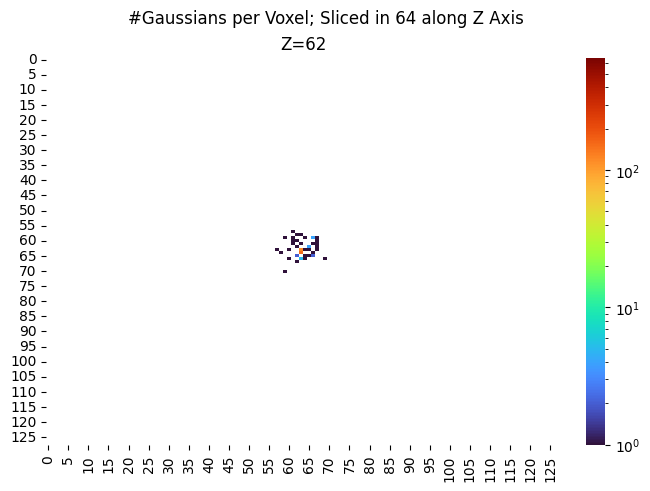

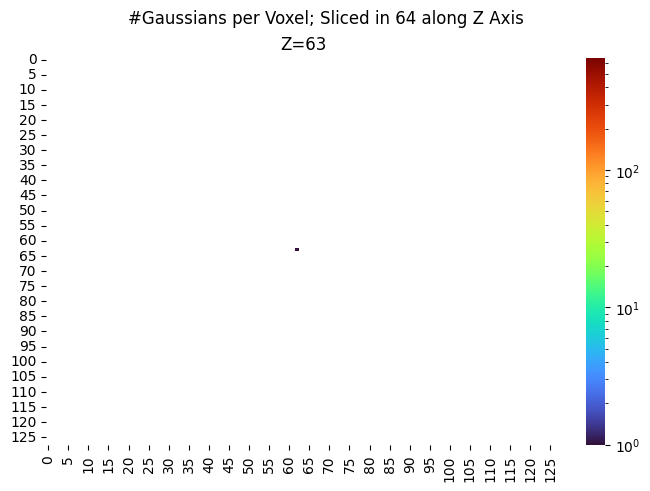

In [19]:

import os


@dataclass
class SliceAxis:
    name: str
    i: int
slice_axis = SliceAxis('Z', 2)

# TODO voxels + min + max + cmap in log space

# fig =plt.figure(figsize=(8.5,11))
# fig.set_layout_engine('compressed')
# axs = fig.subplots(np.ceil(voxels.shape[slice_axis.i]/8).astype(int).item(), 8)
# for i, ax in zip(range(voxels.shape[slice_axis.i]), axs.flat):
# for i in range(voxels.shape[slice_axis.i]):
for i in range(voxels.shape[slice_axis.i]):
    fig, ax = plt.subplots(1,1)
    fig.set_layout_engine('compressed')
    fig.suptitle(f"#Gaussians per Voxel; Sliced in {voxels.shape[slice_axis.i]} along {slice_axis.name} Axis")
    slice = voxels.take(i, slice_axis.i)
    sb.heatmap(slice,norm=norm, cmap=alpha_grad_cmap)
    ax.set_title(f'{slice_axis.name}={i}')
    fig.savefig(os.path.join(experiment_pretty_name,f'z={i}.svg'))